In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


import pandas as pd
import os
import random
import shutil
from shutil import copy
from collections import defaultdict
import tensorflow as tf
import keras.backend as K
from patchify import patchify, unpatchify
from skan import Skeleton, summarize
from skimage.morphology import remove_small_objects, skeletonize
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [2]:
def padder(image, patch_size):
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [3]:
# Let's implement two custom metrics f1 score and iou
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        y_pred = tf.cast(y_pred>0.5,y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)

In [4]:
from keras.models import load_model

model = load_model('modelroot.h5', custom_objects={'f1':f1, 'iou':iou})

In [5]:
def crop_image(image):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    th, output_im = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)
 
    stats = stats[1:]
    for stat in stats:
        if stat[2] > 2000:
            plants = stat
            break
   
    x, y, w, h, area = plants
 
    if w > h:
        l = h
    else:
        l = w
        
    return y, x, l

In [6]:
kernel = np.ones((5, 5), dtype="uint8")

In [7]:
def romove_objects_from_mask(mask):
    mask_d = cv2.dilate(mask, kernel, iterations=1)
    mask_closing = cv2.erode(mask_d, kernel, iterations=1)

    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_closing)

    
    filtered_components = []
    for i in range(1, retval):
        centroid_x, centroid_y = centroids[i]
        if centroid_y < 1800 and centroid_y > 450:
            filtered_components.append(i)

    
    filtered_mask = np.zeros_like(mask_closing)

    for label in filtered_components:
        filtered_mask[labels == label] = 255
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(filtered_mask)

    area_values = stats[1:, cv2.CC_STAT_AREA]
    mean_area = np.mean(area_values)

    min_size = mean_area/5
    alternative = remove_small_objects(labels, min_size = min_size)

    return alternative>0

In [8]:
patch_size = 128

In [9]:
def get_plants(image):

   
    y, x, l = crop_image(image)
    cropped_image = image[y:y+l, x:x+l]

    # Padder the image 
    padded_cut_image = padder(cropped_image, patch_size)
    
    patches = patchify(padded_cut_image, (patch_size, patch_size, 1), step=patch_size)
    
    i = patches.shape[0]
    j = patches.shape[1]
        
    patches = patches.reshape(-1, patch_size, patch_size, 1)
    patches.shape
    
    preds = model.predict(patches/255)
    
    preds = preds.reshape(i, j, 128, 128)
    
    predicted_mask = unpatchify(preds, (padded_cut_image.shape[0], padded_cut_image.shape[1]))

    predicted_mask = predicted_mask > 0.5
    predicted_mask = predicted_mask.astype(np.uint8) * 255

    

    # Clean the mask and convert it to BGR
    mask = romove_objects_from_mask(predicted_mask)
    mask = mask.astype(np.uint8) * 255
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Make a binary copy of the mask
    _, binary_image = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)
    # Get the skeleton
    skeleton = skeletonize(binary_image)
    # Get the skeleton data
    skeleton_data = summarize(Skeleton(skeleton))
    # Sort by the skeleton ID
    skeleton_data = skeleton_data.sort_values(by='skeleton-id', ascending=True)

    # A list of all the skeleton id's
    plants = np.unique(skeleton_data['skeleton-id'])

    # Create a copy of the image
    plant_img = padded_cut_image

    return plants, plant_img,  skeleton_data


In [10]:
def visualistion_of_roots(plants, skeleton_data,plant_img):
    code_measurements = pd.DataFrame(columns = ['V1 x', 'V1 y', 'V2 x', 'V2 y'])
    for plant in plants:
        # Get a new dataframe for the individual skeleton/plant data
        plant_data = skeleton_data[skeleton_data['skeleton-id'] == plant]

        # Get the start and end point of the main root
        start_main_root = plant_data['node-id-src'].min()
        end_main_root = plant_data['node-id-dst'].max()

        # Save the start and end points coordinates for the primary root
        v1_x = plant_data[plant_data['node-id-src'] == start_main_root]['coord-src-0'].values[0]
        v1_y = plant_data[plant_data['node-id-src'] == start_main_root]['coord-src-1'].values[0]
        v2_x = plant_data[plant_data['node-id-dst'] == end_main_root]['coord-dst-0'].values[0]
        v2_y = plant_data[plant_data['node-id-dst'] == end_main_root]['coord-dst-1'].values[0]

        # Save the point coordinates in the 
        code_measurements.loc[len(code_measurements)] = [v1_x, v1_y, v2_x, v2_y]

        # Iterate over the rows in skeleton_data
        for index, row in plant_data.iterrows():
            # Get the coordinates for the points
            x_src = row['coord-src-0']
            y_src = row['coord-src-1']
            x_dst = row['coord-dst-0']
            y_dst = row['coord-dst-1'] 

            radius = 15
            thickness = 2

            # If the point is only a startpoint
            if ~plant_data['node-id-dst'].isin([row['node-id-src']]).any():
                # Get the coordinates for the points
                point_coordinates = (int(y_src), int(x_src))

                # Choose the color
                if row['node-id-src'] == start_main_root:
                    # Green for the junction between the root and the hypocotyl
                    color  = (0, 255, 0)
                else:
                    # Red for secondary root tip
                    color = (0, 0, 255)

                # Draw the circle around the point on the image
                plant_img = cv2.circle(plant_img, point_coordinates, radius, color, thickness)
            
            # If the point is only an endpoint
            if ~plant_data['node-id-src'].isin([row['node-id-dst']]).any():
                # Get the coordinates for the points
                point_coordinates = (int(y_dst), int(x_dst))

                # Choose the color
                if row['node-id-dst'] == end_main_root:
                    # Black for main root tip
                    color = (0, 0, 0)
                else:
                    # Red for secondary root tip
                    color = (0, 0, 255)
                        
                 # Draw the circle around the point on the image
                plant_img = cv2.circle(plant_img, point_coordinates, radius, color, thickness)

            # The point is both an endpoint and a startpoint
            if plant_data['node-id-dst'].isin([row['node-id-src']]).any():
                # Get the coordinates for the points
                point_coordinates = (int(y_src), int(x_src))

                # Blue for junction points
                color = (255, 0, 0)
                        
                # Draw the circle around the point on the image
                plant_img = cv2.circle(plant_img, point_coordinates, radius, color, thickness)

    image_rgb = cv2.cvtColor(plant_img, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.figure(figsize=(15, 15))
    plt.imshow(image_rgb)
    return code_measurements 

16/16 [==============================] - 4s 55ms/step


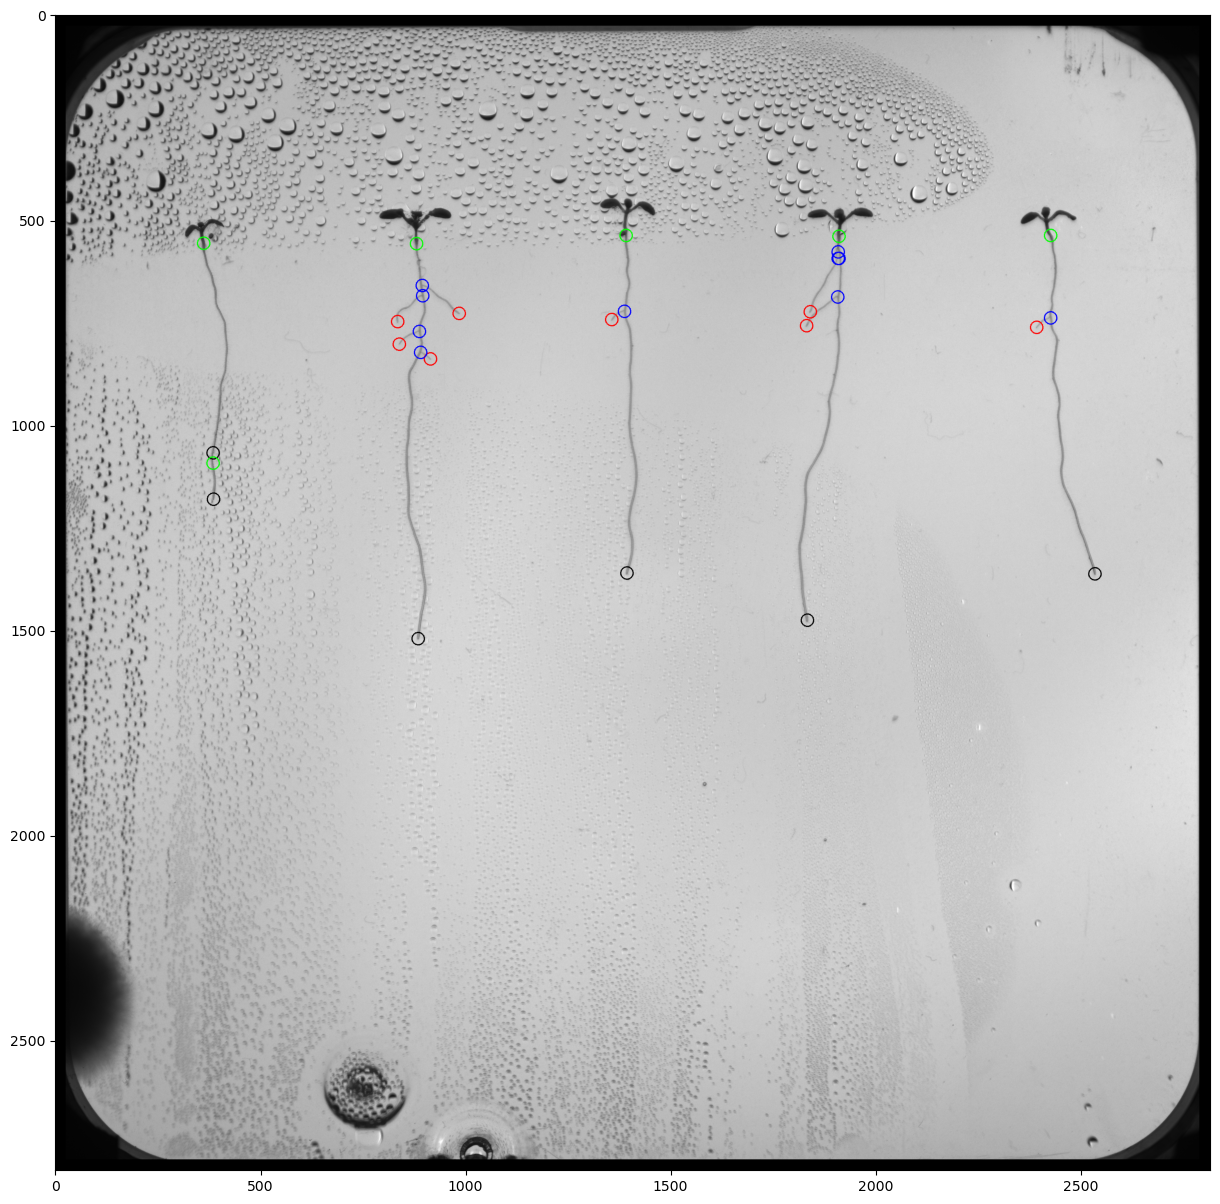

In [11]:
image = cv2.imread(r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task6\images\measurement_image_1.tif")

plants, plant_img,skeleton_data = get_plants(image)

code_measurements = visualistion_of_roots(plants, skeleton_data,plant_img)



In [12]:

def get_data(image_name):
    # Read the dataset
    df = pd.read_excel(f'images/measurements.xlsx', sheet_name=f'{image_name}')
    # Get rid of the empty rows and reset index
    df = df.dropna(how='all').reset_index(drop=True)
    # Drop row with only 1 random element and columns with NaN and the only value of 0
    df = df.drop(index=[0], columns=df.columns[[0, 6, 9]])
    # Rename the columns
    df.columns = df.iloc[0]
    # Remove the rows with the column names and reset index
    df = df[1:].reset_index(drop=True)
    # Get only the primary root data
    primary_root = df[df['Plant 1'] == 'Primary Root'].copy()
    primary_root.iloc[:, 1:] = primary_root.iloc[:, 1:].astype(np.float32)
    # Order the plants based on Y coordiate
    primary_root = primary_root.sort_values(by='V1 y', ascending=True)
    # Get only the coordinates 
    primary_root_msr = primary_root[['V1 x', 'V1 y', 'V2 x', 'V2 y']].sort_values(by='V1 y', ascending=True)

    return primary_root_msr

In [13]:

def calculate_error(image,code_measurements, image_name):

    primary_root_msr = get_data(image_name)
    
    y, x, l = crop_image(image)
    cropped_image = image[y:y+l, x:x+l]


    padded_cut_image = padder(cropped_image, patch_size)


    X = y - (padded_cut_image.shape[0] - l)//2
    Y = x - (padded_cut_image.shape[0] - l)//2
    predictions = pd.DataFrame(columns = ['V1 x', 'V1 y', 'V2 x', 'V2 y'])


    # Imput the values from the code measurements and reverse the changes to the original image
    predictions['V1 x'] = code_measurements['V1 y'] + Y
    predictions['V1 y'] = code_measurements['V1 x'] + X
    predictions['V2 x'] = code_measurements['V2 y'] + Y
    predictions['V2 y'] = code_measurements['V2 x'] + X

    # Sort the plants from left to right and reset the index
    predictions = predictions.sort_values(by='V1 x', ascending=True).reset_index(drop=True)

    # Check to see if there are more than 5 plants
    if len(predictions) > 5:
        # If so, get the root length on 1 axis
        length = pd.DataFrame(columns = ['length']) # Dataframe for lengths
        length['length'] = predictions['V2 y'] - predictions['V1 y']

       # Itterate over all the lengths
        for index, row in length.iterrows():
            # Find the shortest
            if row['length'] == length['length'].min():
                # And remove it
                predictions = predictions.drop(index=[index]).reset_index(drop=True)
                # If there are 5 plants remaining, break
                if len(predictions) == 5:
                    break

    # Check to see if there are no inverted values in the dataset
    for i, row in primary_root_msr.iterrows():
        if row['V1 y'] > row['V2 y']:
        # Using .loc to interchange the values to plot the mean error
            primary_root_msr.loc[i, ['V1 x', 'V2 x']] = primary_root_msr.loc[i, ['V2 x', 'V1 x']].values
            primary_root_msr.loc[i, ['V1 y', 'V2 y']] = primary_root_msr.loc[i, ['V2 y', 'V1 y']].values

    # Sort the plants from left to right and reset the index
    primary_root_msr = primary_root_msr.sort_values(by='V1 x', ascending=True).reset_index(drop=True)

    # Get the error per measurement
    error = predictions - primary_root_msr

    # Print the Mean Absolute Error
    print("Mean Absolute Error:", error.abs().sum().sum()//error.size, "px")


In [14]:
calculate_error(image,code_measurements,"measurement_image_1")

Mean Absolute Error: 10.0 px


## All together:

In [15]:
def visualise_and_calculate_error(image,image_name):


    plants, plant_img, skeleton_data = get_plants(image)

    code_measurements = visualistion_of_roots(plants, skeleton_data,plant_img)

    calculate_error(image,code_measurements,image_name)

In [16]:
image1 = cv2.imread(r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task6\images\measurement_image_1.tif")
image2 = cv2.imread(r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task6\images\measurement_image_2.tif")
image3 = cv2.imread(r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task6\images\measurement_image_3.tif")

image_name1 = "measurement_image_1"
image_name2 = "measurement_image_2"
image_name3 = "measurement_image_3"


16/16 [==============================] - 0s 30ms/step
Mean Absolute Error: 10.0 px
16/16 [==============================] - 0s 29ms/step
Mean Absolute Error: 10.0 px


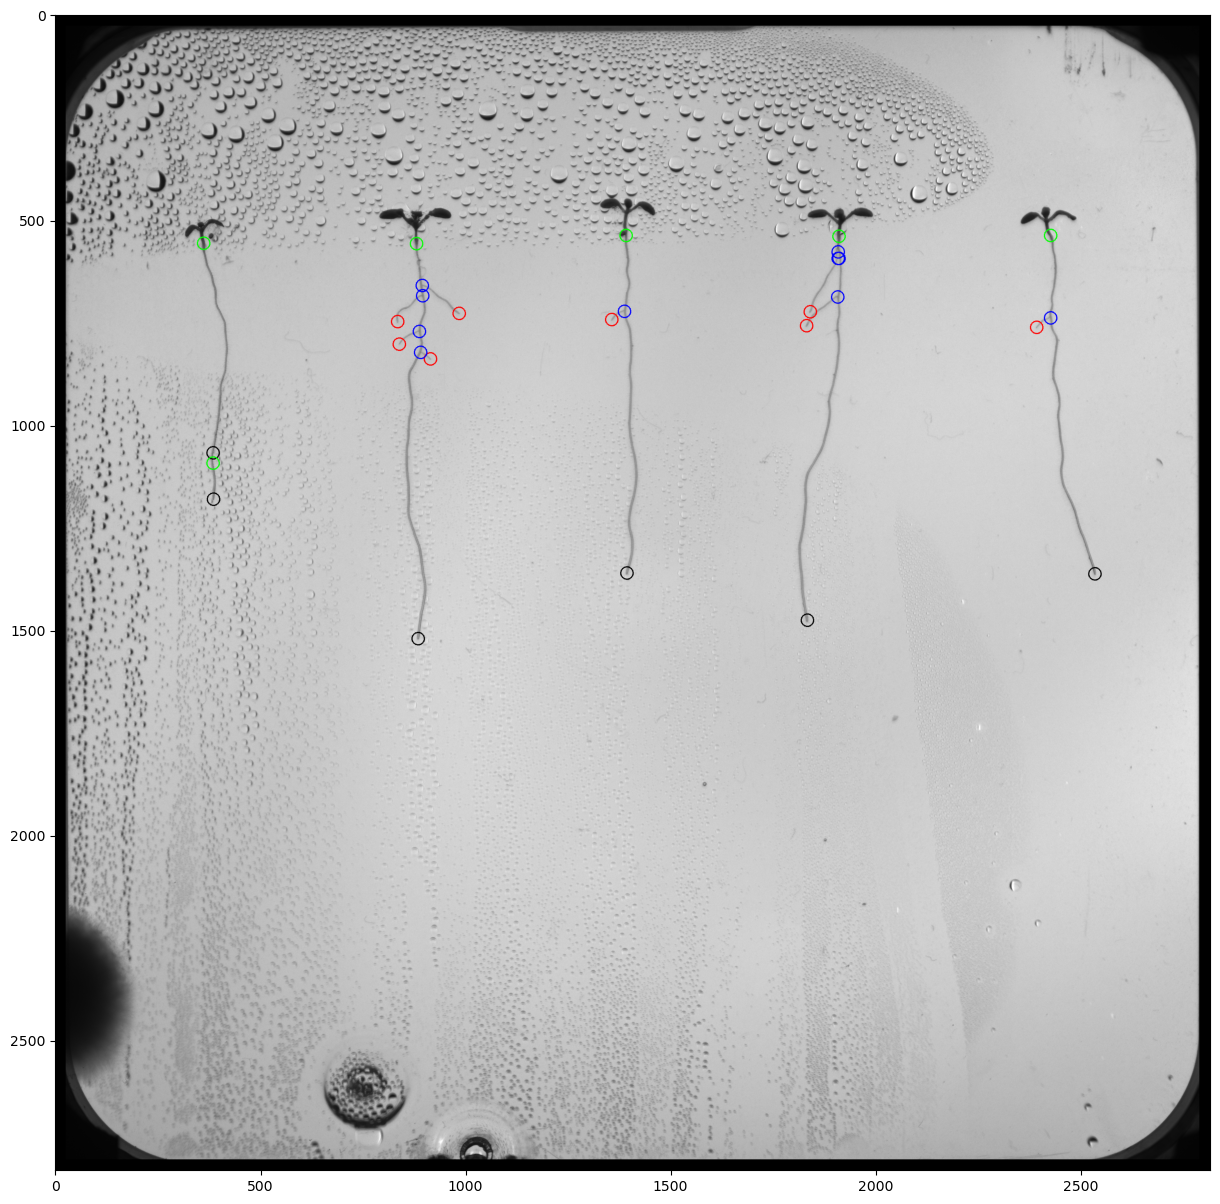

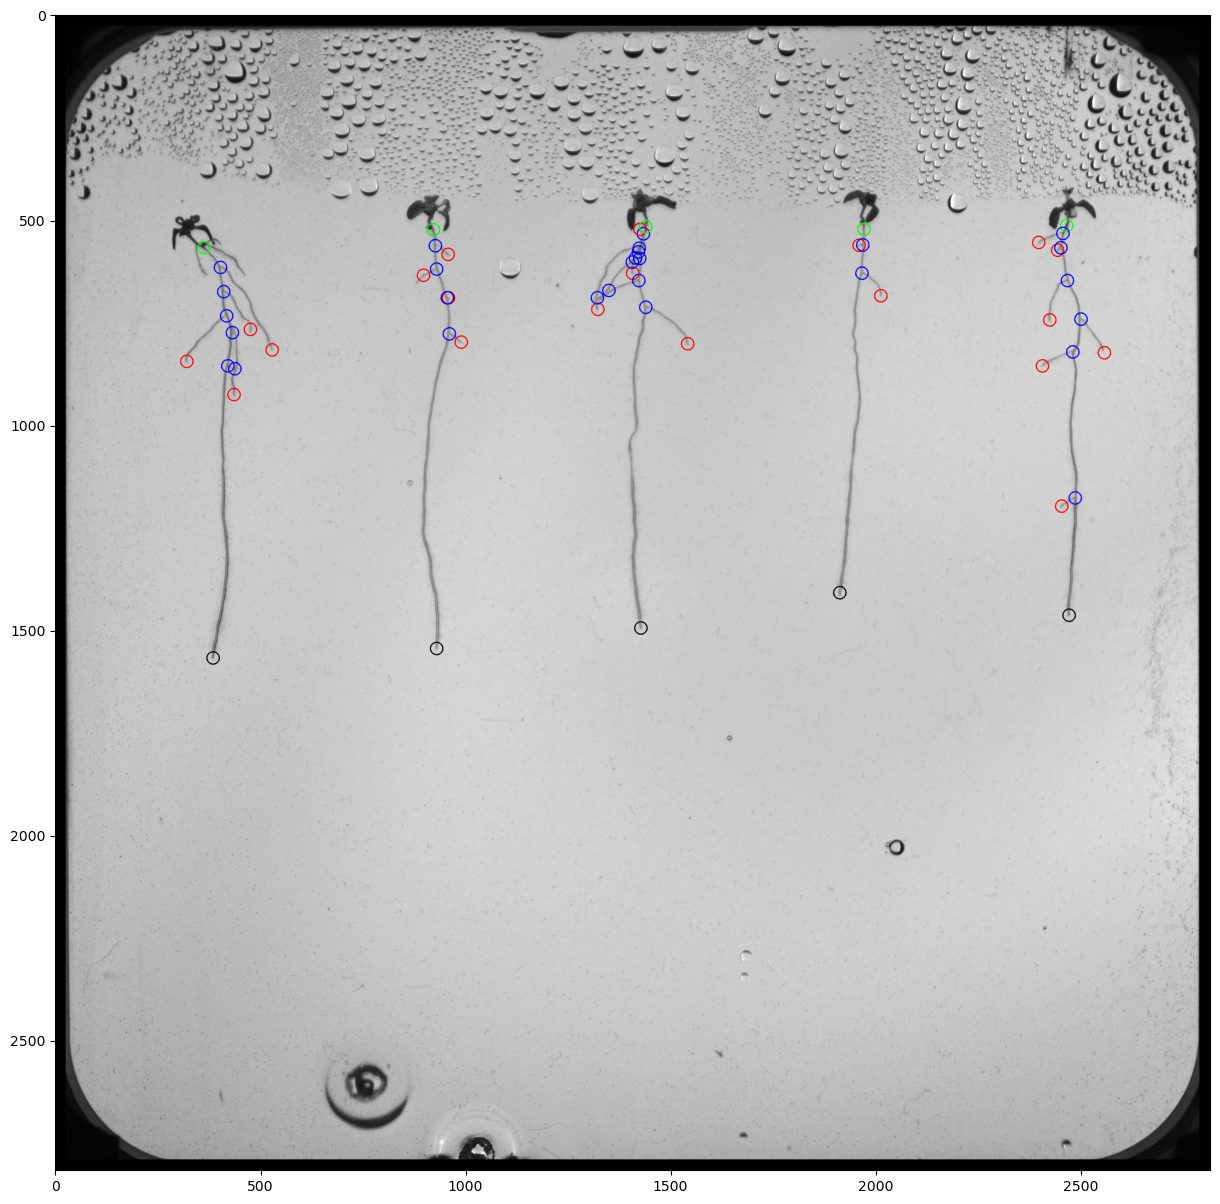

In [17]:
visualise_and_calculate_error(image1,image_name1)
visualise_and_calculate_error(image2,image_name2)
# visualise_and_calculate_error(image3,image_name3)